# Analyze Preds

In [60]:
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px



## lwlrap

In [42]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indiscating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class, precisions_for_samples_by_classes

## Data Prep

In [43]:
class dict2(dict): 
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs) 
        self.__dict__ = self 

config = dict2({
    "fft":                2048,
    "hop":                512,
    "sr":                 48000,
    "mel":                320,
    "SEED":               42,
    "TEST_AUDIO_FLAC":    Path("../input/rfcx-species-audio-detection/test"),
    "TRAIN_AUDIO_ROOT":   Path("e:/002_datasets/000_RFCX/train_mel_clip_aug/"),
    "TEST_AUDIO_ROOT":    Path("../input/rfcx-species-audio-detection/test_mel"),
    "VALID_AUDIO_ROOT":   Path("e:/002_datasets/000_RFCX/valid_mel_clip/"),
    "TRAIN_TP":           Path("../input/rfcx-species-audio-detection/train_tp.csv"),
    "TRAIN_TP_CSV":       Path("../input/rfcx-species-audio-detection/train_tp_mel.csv"),
    "VALID_CSV":          Path("../input/rfcx-species-audio-detection/valid.csv"),
    "TEST_CSV":           Path("../input/rfcx-species-audio-detection/test.csv"),
    "SUB":                Path("../input/rfcx-species-audio-detection/sample_submission.csv"),
})


In [44]:
# Data load
df_train_tp = pd.read_csv(config.TRAIN_TP_CSV)

# add column per birds and flogs
for col in range(24):
    df_train_tp[col] = 0

# one-hot encoding
for index, row in df_train_tp.iterrows():
    specId = row["species_id"]
    for col in range(24):
        if int(specId) == col:
            df_train_tp.iloc[index, df_train_tp.columns.get_loc(col)] = 1

# grouping
# df_train_tp = df_train_tp.groupby("recording_id", as_index=False).max()

# check
print(len(df_train_tp))
display(df_train_tp[df_train_tp["recording_id"] == "77299bde7"].head())


1216


,id,species_id,recording_id,t_min,t_maxs,offs,0,1,2,3,...,14,15,16,17,18,19,20,21,22,23
584,584,8,77299bde7,5.7227,9.8453,274689.6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
585,585,21,77299bde7,42.3787,43.4720,427521.6,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [45]:
# load data
ids = []
specIds = []
record_ids = []
labels = []
offsets = []
for index, row in df_train_tp.iterrows():
    ids.append(row.values[0])
    specIds.append(row.values[1])
    record_ids.append(row.values[2])
    labels.append(row.values[6:30])
    offsets.append(row.values[5])

labels = np.array(labels).astype(float)

print('id', ids[584])
print('specid', specIds[584])
print('recid', record_ids[584])
print('label', labels[584])
print('label shape', labels[584].shape)
print('id len', len(ids))
print('offset', offsets[584])
print('offset', offsets[584] / 48000)

train_tp = df_train_tp.values
print(train_tp[0])

id 584
specid 8
recid 77299bde7
label [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
label shape (24,)
id len 1216
offset 274689.6
offset 5.7227
[0 14 '003bec244' 44.544 45.1307 451839.0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0]


## Analyze Pred

In [172]:
dfs = []
for i in range(5):
    train_batch_preds = np.load('./train_batch_preds_' + str(i) + '.npy')
    train_batch_labels = np.load('./train_batch_labels_' + str(i) + '.npy')
    train_batch_index = np.load('./train_index_fold_' + str(i) + '.npy')

    score, weight, score_per_sample = calculate_per_class_lwlrap(train_batch_labels, train_batch_preds)

    df = pd.DataFrame(train_tp[train_batch_index])
    df["score"] =  score_per_sample.max(axis=1)
    fig = px.box(df.sort_values(1),  y="score", color=1, height=600, width=2100)
    fig.show()

    df_agg = df.groupby(1)["score"].agg(["sum", "count", "min", "max", "mean", "std", "median", lambda x: np.percentile(x, 0.1), lambda x: np.percentile(x, 0.2), lambda x: np.percentile(x, 0.3)]).reset_index()
    df_agg["acc"] = df_agg["sum"] / df_agg["count"]

    display(df_agg.sort_values("acc"))

    dfs.append(df_agg)

    # display(pd.DataFrame(score_per_sample).describe())


,1,sum,count,min,max,mean,std,median,<lambda_0>,<lambda_1>,<lambda_2>,acc
7,7,31.033333,40,0.200000,1.0,0.775833,0.302740,1.0,0.201950,0.203900,0.205850,0.775833
22,22,28.311111,35,0.111111,1.0,0.808889,0.296307,1.0,0.114133,0.117156,0.120178,0.808889
17,17,43.800000,54,0.100000,1.0,0.811111,0.303146,1.0,0.103533,0.107067,0.110600,0.811111
15,15,33.292857,40,0.083333,1.0,0.832321,0.304632,1.0,0.085655,0.087976,0.090298,0.832321
18,18,33.666667,40,0.083333,1.0,0.841667,0.287934,1.0,0.086583,0.089833,0.093083,0.841667
11,11,33.719298,40,0.052632,1.0,0.842982,0.267956,1.0,0.063579,0.074526,0.085474,0.842982
5,5,33.887500,40,0.062500,1.0,0.847187,0.296726,1.0,0.064937,0.067375,0.069812,0.847187
13,13,33.916667,40,0.166667,1.0,0.847917,0.273398,1.0,0.169917,0.173167,0.176417,0.847917
6,6,33.924242,40,0.090909,1.0,0.848106,0.274159,1.0,0.100364,0.109818,0.119273,0.848106
9,9,23.000000,27,0.166667,1.0,0.851852,0.288983,1.0,0.168833,0.171000,0.173167,0.851852


,1,sum,count,min,max,mean,std,median,<lambda_0>,<lambda_1>,<lambda_2>,acc
7,7,33.433333,40,0.200000,1.0,0.835833,0.293945,1.0,0.200000,0.200000,0.200000,0.835833
13,13,33.616667,40,0.166667,1.0,0.840417,0.289436,1.0,0.166667,0.166667,0.166667,0.840417
15,15,35.083333,40,0.250000,1.0,0.877083,0.252472,1.0,0.253250,0.256500,0.259750,0.877083
4,4,35.500000,40,0.333333,1.0,0.887500,0.230778,1.0,0.333333,0.333333,0.333333,0.887500
11,11,35.833333,40,0.333333,1.0,0.895833,0.212459,1.0,0.339833,0.346333,0.352833,0.895833
23,23,72.104701,80,0.076923,1.0,0.901309,0.245077,1.0,0.079624,0.082325,0.085026,0.901309
21,21,36.291667,40,0.125000,1.0,0.907292,0.229867,1.0,0.133125,0.141250,0.149375,0.907292
1,1,36.392857,40,0.142857,1.0,0.909821,0.224859,1.0,0.147036,0.151214,0.155393,0.909821
3,3,36.533333,40,0.200000,1.0,0.913333,0.213878,1.0,0.205200,0.210400,0.215600,0.913333
20,20,29.250000,32,0.166667,1.0,0.914062,0.235212,1.0,0.169250,0.171833,0.174417,0.914062


,1,sum,count,min,max,mean,std,median,<lambda_0>,<lambda_1>,<lambda_2>,acc
2,2,21.282143,29,0.066667,1.0,0.733867,0.386116,1.0,0.066667,0.066667,0.066667,0.733867
0,0,29.405013,40,0.052632,1.0,0.735125,0.374337,1.0,0.053179,0.053726,0.054274,0.735125
14,14,29.435714,40,0.055556,1.0,0.735893,0.345236,1.0,0.057722,0.059889,0.062056,0.735893
23,23,59.029203,80,0.062500,1.0,0.737865,0.363521,1.0,0.064744,0.066989,0.069233,0.737865
1,1,29.695671,40,0.071429,1.0,0.742392,0.352556,1.0,0.072188,0.072948,0.073708,0.742392
17,17,41.045971,54,0.076923,1.0,0.760111,0.352801,1.0,0.078146,0.079369,0.080592,0.760111
22,22,27.640115,36,0.090909,1.0,0.767781,0.366390,1.0,0.091616,0.092323,0.093030,0.767781
15,15,31.414379,40,0.058824,1.0,0.785359,0.343475,1.0,0.060429,0.062035,0.063641,0.785359
16,16,31.501190,40,0.125000,1.0,0.787530,0.340165,1.0,0.125000,0.125000,0.125000,0.787530
6,6,31.518347,40,0.058824,1.0,0.787959,0.340127,1.0,0.059779,0.060735,0.061691,0.787959


,1,sum,count,min,max,mean,std,median,<lambda_0>,<lambda_1>,<lambda_2>,acc
1,1,27.320238,40,0.066667,1.0,0.683006,0.368460,1.0,0.068942,0.071217,0.073492,0.683006
20,20,22.058333,32,0.125000,1.0,0.689323,0.349720,1.0,0.127325,0.129650,0.131975,0.689323
5,5,29.903968,40,0.111111,1.0,0.747599,0.357048,1.0,0.112349,0.113587,0.114825,0.747599
10,10,30.576190,40,0.100000,1.0,0.764405,0.351454,1.0,0.100000,0.100000,0.100000,0.764405
2,2,23.049145,30,0.055556,1.0,0.768305,0.329080,1.0,0.056175,0.056795,0.057415,0.768305
23,23,61.801923,80,0.076923,1.0,0.772524,0.340932,1.0,0.077429,0.077936,0.078442,0.772524
21,21,31.336447,40,0.076923,1.0,0.783411,0.327798,1.0,0.079495,0.082066,0.084637,0.783411
9,9,21.174242,27,0.090909,1.0,0.784231,0.342423,1.0,0.092879,0.094848,0.096818,0.784231
18,18,31.480159,40,0.111111,1.0,0.787004,0.323865,1.0,0.112349,0.113587,0.114825,0.787004
14,14,31.985256,40,0.076923,1.0,0.799631,0.322157,1.0,0.078798,0.080673,0.082548,0.799631


,1,sum,count,min,max,mean,std,median,<lambda_0>,<lambda_1>,<lambda_2>,acc
5,5,33.400000,40,0.200000,1.0,0.835000,0.278473,1.0,0.200000,0.200000,0.200000,0.835000
11,11,34.444444,40,0.111111,1.0,0.861111,0.251302,1.0,0.119778,0.128444,0.137111,0.861111
0,0,34.666667,40,0.333333,1.0,0.866667,0.236306,1.0,0.333333,0.333333,0.333333,0.866667
7,7,35.200000,40,0.166667,1.0,0.880000,0.250788,1.0,0.167967,0.169267,0.170567,0.880000
3,3,35.416667,40,0.250000,1.0,0.885417,0.236221,1.0,0.253250,0.256500,0.259750,0.885417
8,8,35.750000,40,0.083333,1.0,0.893750,0.241661,1.0,0.093083,0.102833,0.112583,0.893750
2,2,26.833333,30,0.333333,1.0,0.894444,0.216571,1.0,0.338167,0.343000,0.347833,0.894444
10,10,36.124242,40,0.090909,1.0,0.903106,0.242072,1.0,0.095164,0.099418,0.103673,0.903106
19,19,30.733333,34,0.200000,1.0,0.903922,0.240617,1.0,0.200000,0.200000,0.200000,0.903922
9,9,24.500000,27,0.500000,1.0,0.907407,0.197924,1.0,0.500000,0.500000,0.500000,0.907407


In [173]:
df_all_train = pd.DataFrame()
for d in dfs:
    df_all_train = pd.concat([df_all, d], axis=0)
df_all_train = df_all_train.groupby(1)[["sum", "count"]].sum().reset_index()
df_all_train["acc"] = df_all_train["sum"] / df_all_train["count"]
df_all_train.sort_values("acc")

,1,sum,count,acc
3,3,55.943347,90,0.621593
9,9,49.788044,61,0.816197
7,7,73.792857,90,0.819921
8,8,74.833333,90,0.831481
11,11,75.069444,90,0.834105
5,5,75.101166,90,0.834457
21,21,75.450000,90,0.838333
18,18,75.847619,90,0.842751
4,4,77.430952,90,0.860344
12,12,77.915152,90,0.865724


In [174]:
dfs = []
for i in range(5):
    train_batch_preds = np.load('./valid_batch_preds_' + str(i) + '.npy')
    train_batch_labels = np.load('./valid_batch_labels_' + str(i) + '.npy')
    train_batch_index = np.load('./valid_index_fold_' + str(i) + '.npy')

    score, weight, score_per_sample = calculate_per_class_lwlrap(train_batch_labels, train_batch_preds)

    df = pd.DataFrame(train_tp[train_batch_index])
    df["score"] =  score_per_sample.max(axis=1)
    fig = px.box(df.sort_values(1),  y="score", color=1, height=600, width=2100)
    fig.show()

    df_agg = df.groupby(1)["score"].agg(["sum", "count", "min", "max", "mean", "std", "median", lambda x: np.percentile(x, 0.1), lambda x: np.percentile(x, 0.2), lambda x: np.percentile(x, 0.3)]).reset_index()
    df_agg["acc"] = df_agg["sum"] / df_agg["count"]

    display(df_agg.sort_values("acc"))

    dfs.append(df_agg)

    # display(pd.DataFrame(score_per_sample).describe())


,1,sum,count,min,max,mean,std,median,<lambda_0>,<lambda_1>,<lambda_2>,acc
3,3,3.592857,10,0.066667,1.0,0.359286,0.296448,0.35,0.066817,0.066967,0.067117,0.359286
9,9,5.000000,7,0.500000,1.0,0.714286,0.267261,0.50,0.500000,0.500000,0.500000,0.714286
0,0,7.291667,10,0.125000,1.0,0.729167,0.360710,1.00,0.126875,0.128750,0.130625,0.729167
5,5,7.666667,10,0.333333,1.0,0.766667,0.306312,1.00,0.333333,0.333333,0.333333,0.766667
1,1,8.000000,10,0.250000,1.0,0.800000,0.329140,1.00,0.250000,0.250000,0.250000,0.800000
18,18,8.000000,10,0.500000,1.0,0.800000,0.258199,1.00,0.500000,0.500000,0.500000,0.800000
8,8,8.000000,10,0.500000,1.0,0.800000,0.258199,1.00,0.500000,0.500000,0.500000,0.800000
11,11,8.333333,10,0.333333,1.0,0.833333,0.272166,1.00,0.334833,0.336333,0.337833,0.833333
7,7,8.500000,10,0.500000,1.0,0.850000,0.241523,1.00,0.500000,0.500000,0.500000,0.850000
20,20,6.833333,8,0.333333,1.0,0.854167,0.273680,1.00,0.334500,0.335667,0.336833,0.854167


,1,sum,count,min,max,mean,std,median,<lambda_0>,<lambda_1>,<lambda_2>,acc
21,21,4.616667,10,0.166667,1.0,0.461667,0.314078,0.416667,0.166667,0.166667,0.166667,0.461667
3,3,4.991667,10,0.125000,1.0,0.499167,0.295555,0.500000,0.125675,0.126350,0.127025,0.499167
5,5,6.084499,10,0.076923,1.0,0.608450,0.428479,0.750000,0.077049,0.077175,0.077301,0.608450
14,14,6.725000,10,0.100000,1.0,0.672500,0.425319,1.000000,0.100225,0.100450,0.100675,0.672500
7,7,7.142857,10,0.142857,1.0,0.714286,0.372931,1.000000,0.144571,0.146286,0.148000,0.714286
11,11,7.541667,10,0.041667,1.0,0.754167,0.399870,1.000000,0.043542,0.045417,0.047292,0.754167
17,17,10.811111,14,0.111111,1.0,0.772222,0.334407,1.000000,0.112267,0.113422,0.114578,0.772222
12,12,7.750000,10,0.250000,1.0,0.775000,0.299305,1.000000,0.252250,0.254500,0.256750,0.775000
1,1,7.916667,10,0.250000,1.0,0.791667,0.336214,1.000000,0.250750,0.251500,0.252250,0.791667
8,8,8.166667,10,0.333333,1.0,0.816667,0.298660,1.000000,0.333333,0.333333,0.333333,0.816667


,1,sum,count,min,max,mean,std,median,<lambda_0>,<lambda_1>,<lambda_2>,acc
3,3,5.058824,10,0.058824,1.0,0.505882,0.430312,0.25,0.059044,0.059265,0.059485,0.505882
4,4,5.197619,10,0.047619,1.0,0.519762,0.364119,0.50,0.048990,0.050362,0.051733,0.519762
12,12,5.790909,10,0.090909,1.0,0.579091,0.324003,0.50,0.091891,0.092873,0.093855,0.579091
16,16,5.874242,10,0.083333,1.0,0.587424,0.387949,0.50,0.083402,0.083470,0.083538,0.587424
8,8,6.583333,10,0.250000,1.0,0.658333,0.305429,0.50,0.250750,0.251500,0.252250,0.658333
15,15,6.809524,10,0.142857,1.0,0.680952,0.350503,0.75,0.144571,0.146286,0.148000,0.680952
17,17,9.666667,14,0.166667,1.0,0.690476,0.332416,0.75,0.168833,0.171000,0.173167,0.690476
21,21,7.750000,10,0.250000,1.0,0.775000,0.299305,1.00,0.252250,0.254500,0.256750,0.775000
0,0,8.000000,10,0.500000,1.0,0.800000,0.258199,1.00,0.500000,0.500000,0.500000,0.800000
7,7,8.200000,10,0.200000,1.0,0.820000,0.301109,1.00,0.202700,0.205400,0.208100,0.820000


,1,sum,count,min,max,mean,std,median,<lambda_0>,<lambda_1>,<lambda_2>,acc
3,3,4.091667,10,0.100000,1.0,0.409167,0.342883,0.266667,0.100225,0.100450,0.100675,0.409167
18,18,6.200000,10,0.200000,1.0,0.620000,0.278089,0.500000,0.202700,0.205400,0.208100,0.620000
2,2,4.350490,7,0.058824,1.0,0.621499,0.473117,1.000000,0.059221,0.059618,0.060015,0.621499
7,7,6.250000,10,0.166667,1.0,0.625000,0.340773,0.500000,0.167417,0.168167,0.168917,0.625000
8,8,6.333333,10,0.250000,1.0,0.633333,0.329140,0.500000,0.250000,0.250000,0.250000,0.633333
1,1,6.960145,10,0.043478,1.0,0.696014,0.400312,1.000000,0.045337,0.047196,0.049054,0.696014
11,11,8.000000,10,0.500000,1.0,0.800000,0.258199,1.000000,0.500000,0.500000,0.500000,0.800000
4,4,8.233333,10,0.066667,1.0,0.823333,0.373191,1.000000,0.067567,0.068467,0.069367,0.823333
21,21,8.250000,10,0.250000,1.0,0.825000,0.289875,1.000000,0.252250,0.254500,0.256750,0.825000
22,22,7.500000,9,0.500000,1.0,0.833333,0.250000,1.000000,0.500000,0.500000,0.500000,0.833333


,1,sum,count,min,max,mean,std,median,<lambda_0>,<lambda_1>,<lambda_2>,acc
3,3,2.791667,10,0.055556,0.5,0.279167,0.152771,0.291667,0.056056,0.056556,0.057056,0.279167
9,9,2.088044,7,0.045455,1.0,0.298292,0.347336,0.142857,0.045535,0.045615,0.045695,0.298292
4,4,7.333333,10,0.250000,1.0,0.733333,0.350925,1.000000,0.250000,0.250000,0.250000,0.733333
21,21,7.500000,10,0.500000,1.0,0.750000,0.263523,0.750000,0.500000,0.500000,0.500000,0.750000
18,18,7.571429,10,0.071429,1.0,0.757143,0.337054,1.000000,0.075286,0.079143,0.083000,0.757143
12,12,7.674242,10,0.090909,1.0,0.767424,0.378957,1.000000,0.092341,0.093773,0.095205,0.767424
11,11,7.750000,10,0.166667,1.0,0.775000,0.364408,1.000000,0.167417,0.168167,0.168917,0.775000
14,14,8.200000,10,0.200000,1.0,0.820000,0.301109,1.000000,0.202700,0.205400,0.208100,0.820000
7,7,8.500000,10,0.500000,1.0,0.850000,0.241523,1.000000,0.500000,0.500000,0.500000,0.850000
17,17,11.500000,13,0.500000,1.0,0.884615,0.219265,1.000000,0.500000,0.500000,0.500000,0.884615


In [175]:
df_all = pd.DataFrame()
for d in dfs:
    df_all = pd.concat([df_all, d], axis=0)
df_all = df_all.groupby(1)[["sum", "count"]].sum().reset_index()
df_all["acc"] = df_all["sum"] / df_all["count"]
df_all.sort_values("acc")

,1,sum,count,acc
3,3,20.526681,50,0.410534
21,21,37.116667,50,0.742333
9,9,25.288044,34,0.743766
7,7,38.592857,50,0.771857
18,18,38.747619,50,0.774952
8,8,39.083333,50,0.781667
4,4,39.597619,50,0.791952
12,12,39.915152,50,0.798303
11,11,40.625000,50,0.812500
17,17,56.594444,68,0.832271


In [176]:
df_all_train.sort_values("acc")

,1,sum,count,acc
3,3,55.943347,90,0.621593
9,9,49.788044,61,0.816197
7,7,73.792857,90,0.819921
8,8,74.833333,90,0.831481
11,11,75.069444,90,0.834105
5,5,75.101166,90,0.834457
21,21,75.450000,90,0.838333
18,18,75.847619,90,0.842751
4,4,77.430952,90,0.860344
12,12,77.915152,90,0.865724


In [181]:
df_train = pd.read_csv(config.TRAIN_TP)
len(df_train)

1216

In [195]:
dfs = []
allscores = np.zeros(len(df_train))
for i in range(5):
    train_batch_preds = np.load('./train_batch_preds_' + str(i) + '.npy')
    train_batch_labels = np.load('./train_batch_labels_' + str(i) + '.npy')
    train_batch_index = np.load('./train_index_fold_' + str(i) + '.npy')

    score, weight, score_per_sample = calculate_per_class_lwlrap(train_batch_labels, train_batch_preds)
    allscores[train_batch_index] = score_per_sample.max(axis=1)

df_train["train_score"] = allscores

In [196]:
dfs = []
allscores = np.zeros(len(df_train))
for i in range(5):
    valid_batch_preds = np.load('./valid_batch_preds_' + str(i) + '.npy')
    valid_batch_labels = np.load('./valid_batch_labels_' + str(i) + '.npy')
    valid_batch_index = np.load('./valid_index_fold_' + str(i) + '.npy')

    score, weight, score_per_sample = calculate_per_class_lwlrap(valid_batch_labels, valid_batch_preds)

    allscores[valid_batch_index] = score_per_sample.max(axis=1)

df_train["valid_score"] = allscores

In [198]:
df_train["dur"] = df_train["t_max"] - df_train["t_min"]
df_train["f_dur"] = df_train["f_max"] - df_train["f_min"]
df_train

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,valid_score,train_score,dur,f_dur
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,0.125000,0.500000,0.5867,3000.000
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,1.000000,0.090909,6.0837,4048.240
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,0.090909,1.000000,3.1360,2718.750
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,0.333333,1.000000,3.7790,3100.780
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,1.000000,1.000000,2.4439,9905.239
...,...,...,...,...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75,1.000000,1.000000,0.6240,750.000
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25,1.000000,1.000000,2.1866,1500.000
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00,1.000000,1.000000,0.7946,2343.750
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20,0.166667,1.000000,2.3520,5624.950


In [200]:
fig = px.imshow(df_train.corr())
fig.show()

```
3	3	20.526681	50	0.410534
21	21	37.116667	50	0.742333
9	9	25.288044	34	0.743766
7	7	38.592857	50	0.771857
18	18	38.747619	50	0.774952
8	8	39.083333	50	0.781667
4	4	39.597619	50	0.791952
12	12	39.915152	50	0.798303
```

```
20	20	36.666667	40	0.916667
13	13	46.452381	50	0.929048
22	22	41.000000	44	0.931818
23	23	95.438095	100	0.954381
10	10	48.166667	50	0.963333
19	19	41.566667	43	0.966667
6	6	49.200000	50	0.984000
```

In [206]:
pd.set_option('display.max_columns', 100)


In [258]:
df_train_agg = df_train[["species_id", "f_min", "f_max", "dur", "f_dur", "t_min", "t_max", "valid_score"]].groupby("species_id", as_index=False).agg(["min", "max", "mean", "std"]).reset_index()

In [259]:
df_train_agg[df_train_agg["species_id"] == 3]

species_id    f_min                          f_max                       \
                  min      max     mean  std     min     max    mean  std   
3          3  1031.25  1031.25  1031.25  0.0  2812.5  2812.5  2812.5  0.0   

      dur                                f_dur                        t_min  \
      min     max      mean       std      min      max     mean  std   min   
3  0.7413  0.7414  0.741328  0.000045  1781.25  1781.25  1781.25  0.0  1.28   

                                  t_max                                 \
       max      mean        std     min      max       mean        std   
3  59.2533  30.48768  18.030301  2.0213  59.9947  31.229008  18.030297   

  valid_score                           
          min  max      mean       std  
3    0.055556  1.0  0.410534  0.315586

In [260]:
df_train_agg[df_train_agg["species_id"] == 6]

species_id  f_min                      f_max                                \
                min    max   mean  std     min      max      mean        std   
6          6  562.5  562.5  562.5  0.0  3187.5  4406.25  4186.875  472.98217   

      dur                              f_dur                                \
      min    max      mean       std     min      max      mean        std   
6  2.0213  2.144  2.121924  0.047597  2625.0  3843.75  3624.375  472.98217   

    t_min                                  t_max                      \
      min      max       mean        std     min      max       mean   
6  0.1173  57.7013  29.873594  17.599127  2.2613  59.8453  31.995518   

             valid_score                        
         std         min  max   mean       std  
6  17.600068         0.2  1.0  0.984  0.113137

In [266]:
df_train_agg.sort_values([('valid_score', 'mean')])

species_id      f_min                                          f_max  \
                     min        max          mean         std       min   
3           3   1031.250   1031.250   1031.250000    0.000000   2812.50   
21         21   3281.250   3281.250   3281.250000    0.000000   4125.00   
9           9    843.750   1125.000    934.742647  133.553835   5250.00   
7           7   4687.500   4687.500   4687.500000    0.000000  11437.50   
18         18   3187.500   3187.500   3187.500000    0.000000   5062.50   
8           8   3750.000   3750.000   3750.000000    0.000000   5531.25   
4           4   2343.750   2531.250   2388.750000   80.891083   4031.25   
12         12    562.500    562.500    562.500000    0.000000   3281.25   
11         11   1808.790   1808.790   1808.790000    0.000000   5684.77   
17         17   1312.500   1464.260   1349.853676   52.868108   3937.50   
5           5   4781.250   5062.500   4786.875000   39.774756  10406.20   
14         14   2531.250   3750.000   2990.625000  492.904452   4406.25   
1           1   3843.750   3843.750   3843.750000    0.000000   5625.00   
15         15     93.750     93.750     93.750000    0.000000   1125.00   
16         16   3093.750   3093.750   3093.750000    0.000000   4593.75   
0           0   5906.250   5906.250   5906.250000    0.000000   7500.00   
2           2    468.750    468.750    468.750000    0.000000   3000.00   
20         20   1312.500   2343.750   1905.468750  516.285634   5718.75   
13         13     93.750     93.750     93.750000    0.000000    843.75   
22         22  10687.500  10687.500  10687.500000    0.000000  13687.50   
23         23   6459.960   7235.160   6847.560000  389.552657  11283.40   
10         10    947.461    947.461    947.461000    0.000000  10852.70   
19         19    281.250    281.250    281.250000    0.000000   2812.50   
6           6    562.500    562.500    562.500000    0.000000   3187.50   

                                           dur                    \
         max          mean         std     min     max      mean   
3    2812.50   2812.500000    0.000000  0.7413  0.7414  0.741328   
21   4125.00   4125.000000    0.000000  1.0933  1.0934  1.093352   
9    5718.75   5567.095588  222.589725  2.8053  3.5627  3.317662   
7   11437.50  11437.500000    0.000000  3.1413  3.1414  3.141336   
18   5062.50   5062.500000    0.000000  0.6933  0.6934  0.693326   
8    5531.25   5531.250000    0.000000  4.1226  4.1227  4.122662   
4    4218.75   4173.750000   80.891083  1.8560  2.1867  1.935358   
12   3281.25   3281.250000    0.000000  3.1360  3.1360  3.136000   
11   5684.77   5684.770000    0.000000  1.1377  1.1378  1.137780   
17   7406.25   4187.686765  827.165508  2.5333  6.4534  4.951675   
5   11250.00  10423.076000  119.331340  2.3520  3.1093  2.367146   
14   6468.75   5321.250000  865.174425  0.2720  0.9227  0.639684   
1    5625.00   5625.000000    0.000000  0.8960  0.8960  0.896000   
15   1125.00   1125.000000    0.000000  3.3440  3.3440  3.344000   
16   4593.75   4593.750000    0.000000  1.8346  1.8347  1.834670   
0    8250.00   8100.000000  303.045763  0.7946  1.2907  0.893866   
2    3000.00   3000.000000    0.000000  1.7760  1.7760  1.776000   
20   6093.75   5878.125000  187.740231  3.4400  5.3814  4.265067   
13   1406.25    855.000000   79.549513  0.6240  3.8720  0.688960   
22  13687.50  13687.500000    0.000000  1.6053  1.6054  1.605341   
23  11627.90  11455.650000  173.117764  6.0836  7.9239  7.003716   
10  10852.70  10852.700000    0.000000  2.4438  2.4439  2.443898   
19   2812.50   2812.500000    0.000000  1.5520  1.5520  1.552000   
6    4406.25   4186.875000  472.982170  2.0213  2.1440  2.121924   

                     f_dur                                      t_min  \
             std       min       max         mean         std     min   
3   4.535574e-05  1781.250  1781.250  1781.250000    0.000000  1.2800   
21  5.046720e-05   843.750   843.750   843.750000    0.000000  0

In [250]:
recids =  df_train.groupby("recording_id").count().reset_index()[df_train.groupby("recording_id").count().reset_index()["species_id"] > 1].sort_values("recording_id")["recording_id"].values

In [251]:
pd.set_option('display.max_rows', 200)


In [290]:
df_train[df_train["recording_id"].isin(recids)].sort_values("recording_id")

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,valid_score,train_score,dur,f_dur
19,03b96f209,16,4,30.9333,3093.750,32.7680,4593.75,1.000000,1.000000,1.8347,1500.000
20,03b96f209,16,4,49.6320,3093.750,51.4667,4593.75,0.500000,1.000000,1.8347,1500.000
28,053aeb7bd,23,4,9.8569,6459.960,17.7807,11627.90,1.000000,1.000000,7.9238,5167.940
29,053aeb7bd,23,4,0.9520,6459.960,8.8758,11627.90,1.000000,1.000000,7.9238,5167.940
75,11c2c02e5,15,1,17.6587,93.750,21.0027,1125.00,1.000000,1.000000,3.3440,1031.250
76,11c2c02e5,15,1,14.8427,93.750,18.1867,1125.00,1.000000,1.000000,3.3440,1031.250
102,160add406,23,4,18.6805,6459.960,26.6043,11627.90,1.000000,1.000000,7.9238,5167.940
103,160add406,23,4,3.0534,6459.960,10.9772,11627.90,1.000000,1.000000,7.9238,5167.940
107,16553d5cd,23,4,41.7088,6459.960,49.6327,11627.90,1.000000,1.000000,7.9239,5167.940
106,16553d5cd,23,4,28.7405,6459.960,36.6643,11627.90,1.000000,1.000000,7.9238,5167.940


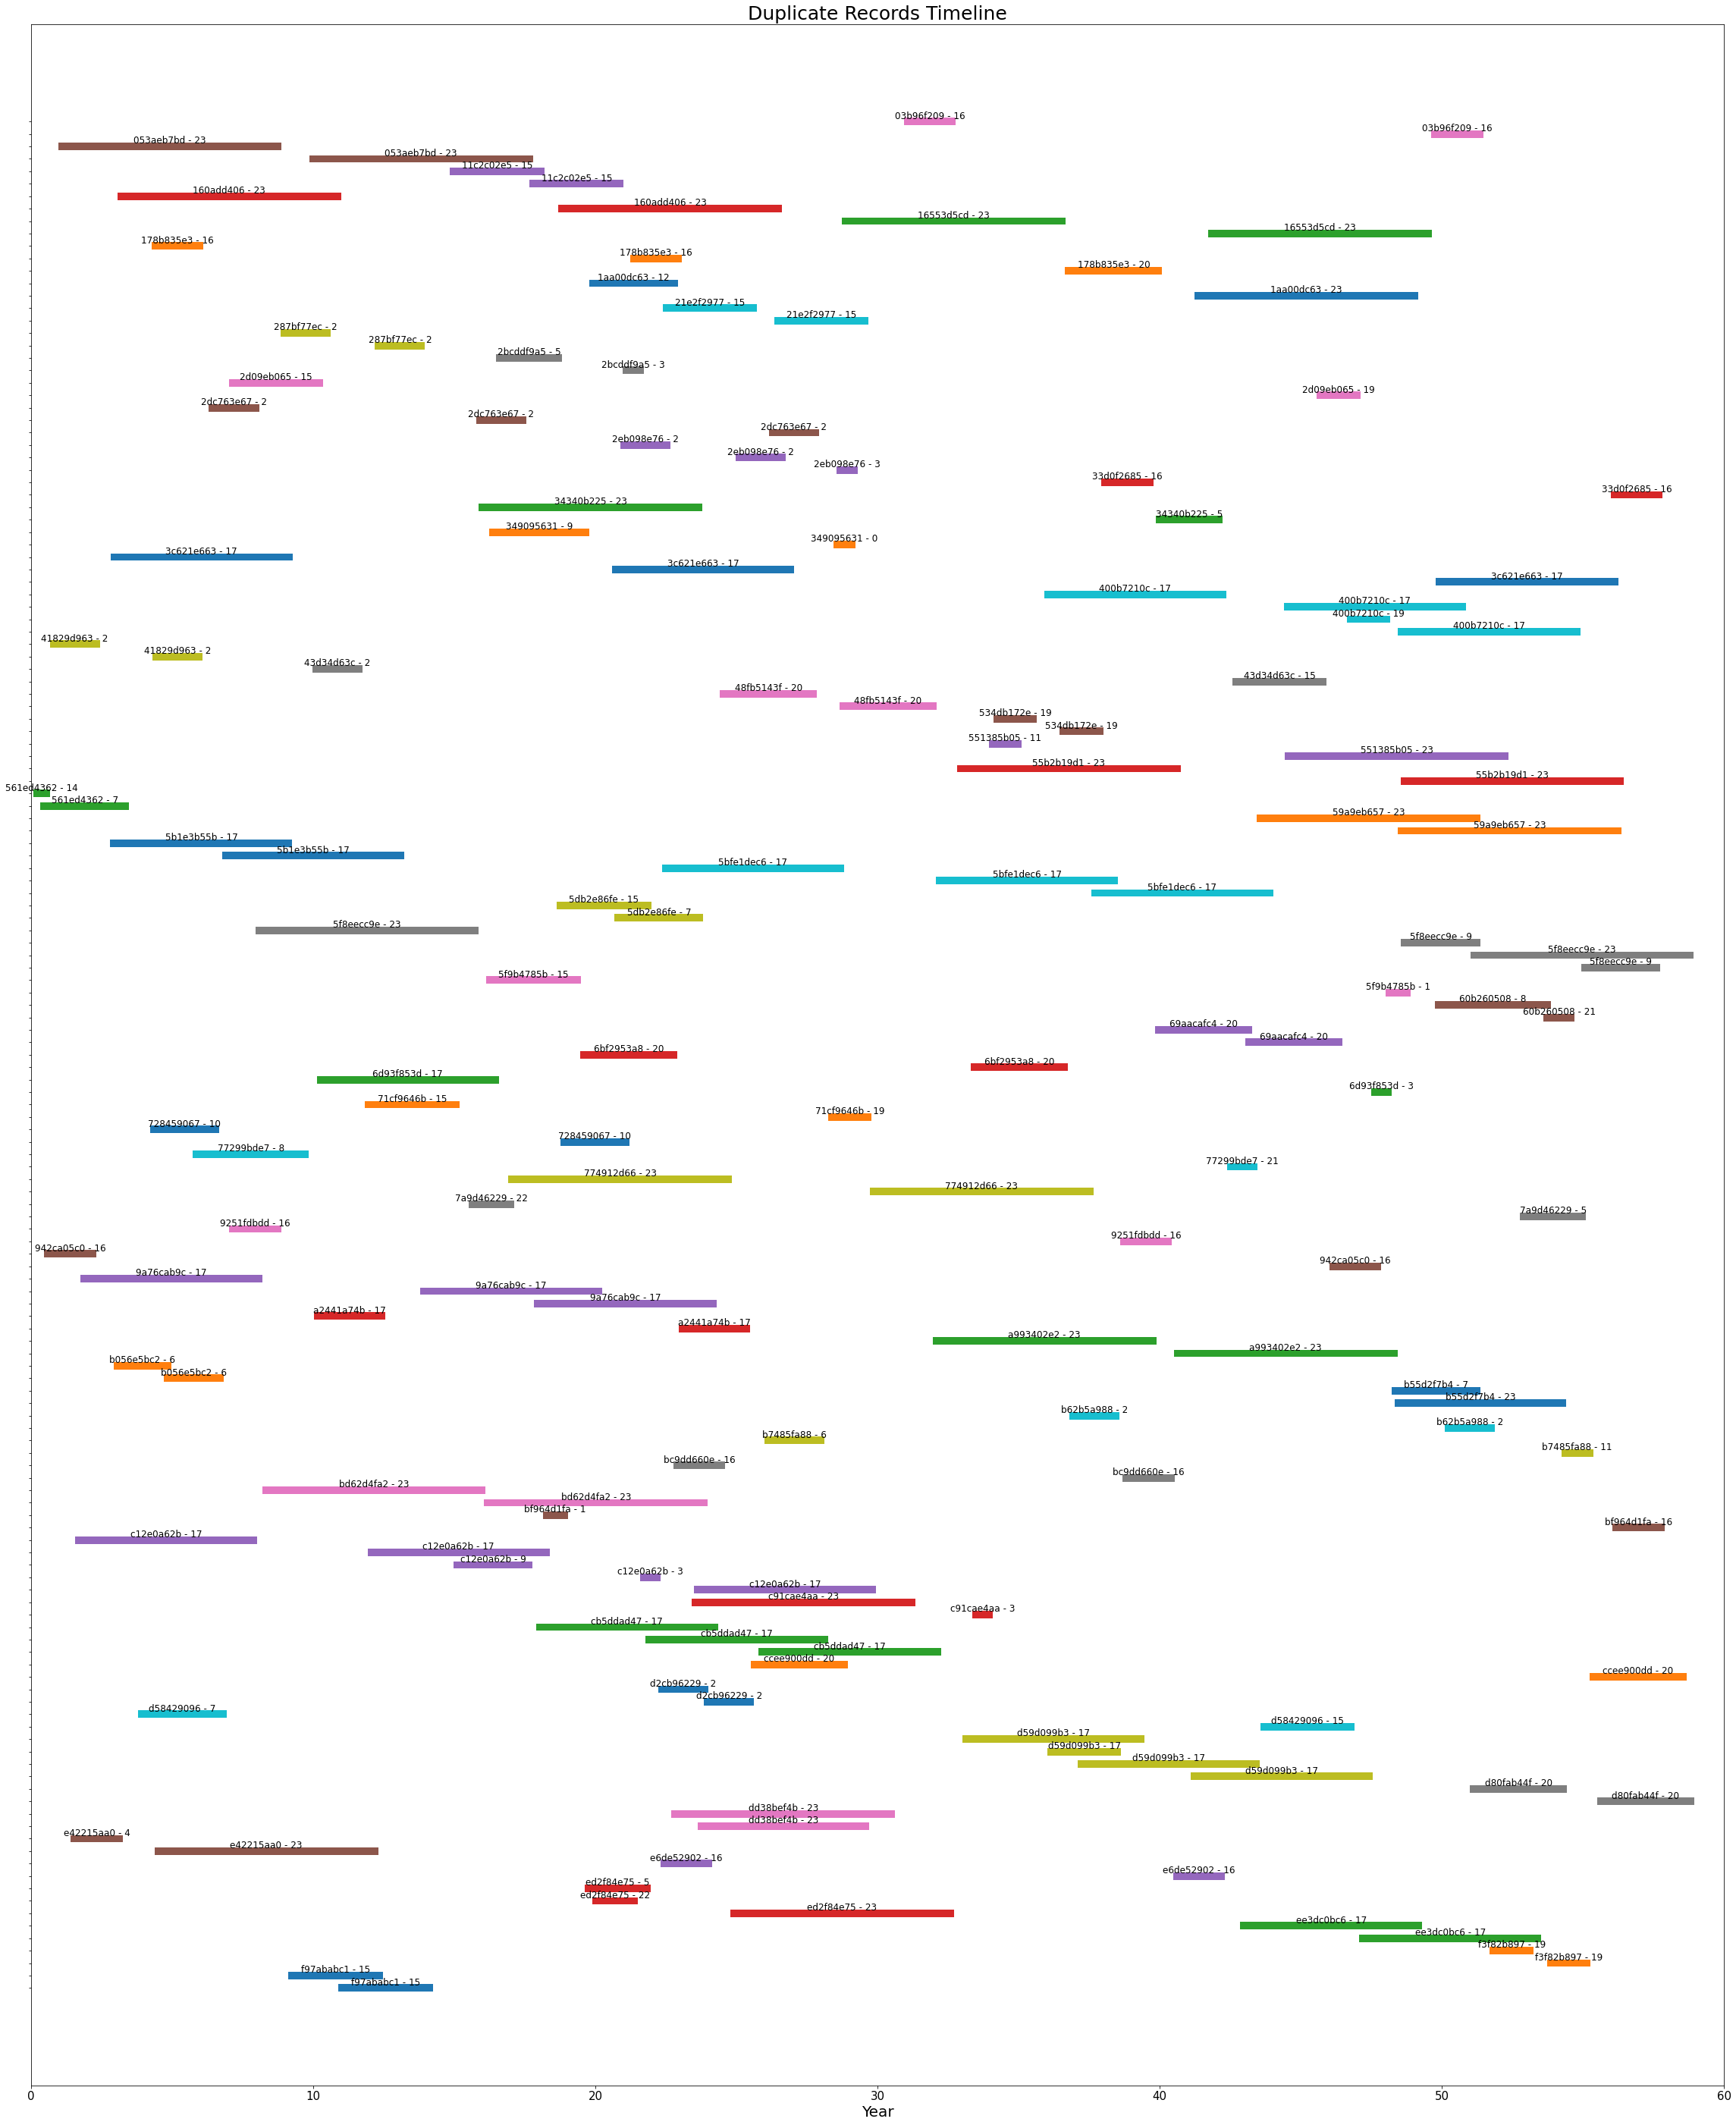

In [322]:
import matplotlib.pyplot as plt

xia = df_train[df_train["recording_id"].isin(recids)].sort_values(["recording_id", "t_min"], ascending=False)
event = xia['recording_id']
begin = xia['t_min']
end = xia['t_max']
length =  xia['t_max'] - xia['t_min']
specs = xia['species_id']


plt.figure(figsize=(40,50))
# plt.barh(range(len(begin)), (end-begin), .6, left=begin)
nums = []
ends = []
begins = []
events = []
prev_recid = ""
for i in range(len(df_train[df_train["recording_id"].isin(recids)])):

    if prev_recid == "":
        prev_recid = event.iloc[i]

    if prev_recid != event.iloc[i]:
        # barh = plt.barh([i], [end.iloc[i]-begin.iloc[i]], .6, left=begin.iloc[i], label=event.iloc[i])
        barh = plt.barh(nums, np.array(ends)-np.array(begins), .6, left=begins, label=events)
        nums = []
        ends = []
        begins = []
        events = []
    prev_recid = event.iloc[i]

    nums.append(i)
    ends.append(end.iloc[i])
    begins.append(begin.iloc[i])
    events.append(event.iloc[i])
barh = plt.barh(nums, np.array(ends)-np.array(begins), .6, left=begins, label=events)


    
handles.append(barh)


plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.title('Duplicate Records Timeline', fontsize = '25')
plt.xlabel('Year', fontsize = '20')
plt.yticks(range(len(begin)), "")
plt.xlim(0, 60)
# plt.ylim(-1,18)
for i in range(len(df_train[df_train["recording_id"].isin(recids)])):
    plt.text(begin.iloc[i] + length.iloc[i]/2, 
             i+.25, str(event.iloc[i]) + ' - ' + str(specs.iloc[i]), 
             ha='center', fontsize = '12')
# plt.legend()